In [3]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(ch:pa_eda)=
# Exploring PurpleAir and AQS Measurements 

Let's explore the cleaned dataset of matched AQS and PurpleAir PM2.5 readings and look for insights that might help us in modeling.
Our main interest is in the relationship between the two sources of air quality measurements. But we want to keep in mind the scope of the data, like how these data are situated in time and place. We learned from our data cleaning that we are working with daily averages of PM2.5 for a couple of years and that we have data from dozens of locations across the US.

First we review the entire cleaned dataframe:

In [4]:
csv_file = 'data/cleaned_purpleair_aqs/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'TempC', 'RH', 'Dewpoint']
full_df = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full_df.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'temp', 'rh', 'dew']

In [5]:
full_df

,date,id,region,pm25aqs,pm25pa,temp,rh,dew
0,2019-05-17,AK1,Alaska,6.7,8.62,18.03,38.56,3.63
1,2019-05-18,AK1,Alaska,3.8,3.49,16.12,49.40,5.44
2,2019-05-21,AK1,Alaska,4.0,3.80,19.90,29.97,1.73
...,...,...,...,...,...,...,...,...
12427,2019-02-20,WI6,North,15.6,25.30,1.71,65.78,-4.08
12428,2019-03-04,WI6,North,14.0,8.21,-14.38,48.21,-23.02
12429,2019-03-22,WI6,North,5.8,9.44,5.08,52.20,-4.02


We include an explanation for each of the columns in our dataframe in the following table:

| Column  | Description                                                                                                                      |
|---------|----------------------------------------------------------------------------------------------------------------------------------|
| date    | Date of the observation                                                                                                          |
| id      | A unique label for a site, formatted as the US state abbreviation with a number (we performed data cleaning for site ID `CA1`) |
| region  | The name of the region, which corresponds to a group of sites (the `CA1` site is located in the `West` region)                 |
| pm25aqs | The PM2.5 measurement from the AQS sensor                                                                                       |
| pm25pa  | The PM2.5 measurement from the PurpleAir sensor                                                                                 |
| temp    | Temperature, in Celcius                                                                                                         |
| rh      | Relative humidity, ranging from 0% to 100%                                                                                       |
| dew     | The dew point (a higher dew point means more moisture is in the air)                                                     |

Let's start with making a few simple visualizations to gain insight. Since the scope involves measurements over time at particular locations, we can choose one location with many measurements and make a line plot of the weekly average air quality. To choose, let's find the sites with many records:

In [6]:
full_df['id'].value_counts()[:3]

id
IA3    830
NC4    699
CA2    659
Name: count, dtype: int64

The location labeled `NC4`, has nearly 700 observations. To smooth the line plot a bit, let's plot weekly averages:  

In [7]:
nc4 = full_df.loc[full_df['id'] =='NC4']

In [8]:
ts_nc4 = (nc4.set_index('date')
 .resample('W')
 ['pm25aqs', 'pm25pa']
 .mean()
 .reset_index()
)

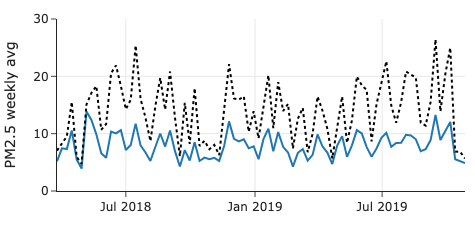

In [9]:
fig = px.line(ts_nc4, x='date', y='pm25aqs',
              labels={'date':'', 'pm25aqs':'PM2.5 weekly avg'},
              width=500, height=250)

fig.add_trace(go.Scatter(x=ts_nc4['date'], y=ts_nc4['pm25pa'],
                         line=dict(color='black', dash='dot')))

fig.update_yaxes(range=[0,30])
fig.update_layout(showlegend=False)
fig.show()

We see that most PM2.5 values for the AQS sensor (solid line) range between 5.0 and 15.0 µg m⁻³.
The PurpleAir sensor follows the up-and-down pattern of the AQS sensor, which is reassuring. 
But the measurements are consistently higher than AQS and, in some cases, quite a bit higher, which tells us that a correction might be helpful. 

Next, let's consider the distributions of the PM2.5 readings for the two sensors:

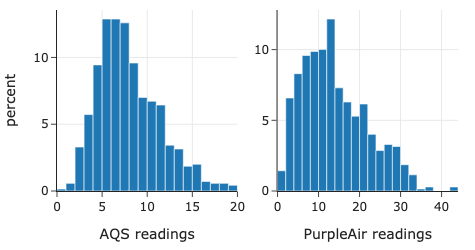

In [10]:
left= px.histogram(nc4, x='pm25aqs', histnorm='percent')
right = px.histogram(nc4, x='pm25pa', histnorm='percent')

fig = left_right(left, right, width=600, height=250)
fig.update_xaxes(title='AQS readings', col=1, row=1)
fig.update_xaxes(title='PurpleAir readings', col=2, row=1)
fig.update_yaxes(title='percent', col=1, row=1)
fig.show()

Both distributions are skewed right, which often happens when there's a lower bound on values (in this case, 0).
A better way to compare these two distributions is with a quantile-quantile plot (see {numref}`Chapter %s <ch:eda>`).
With a q–q plot it can be easier to compare means, spreads, and tails:

In [11]:
percs = np.arange(1, 100, 1)
aqs_qs = np.percentile(nc4['pm25aqs'], percs, interpolation='lower')
pa_qs = np.percentile(nc4['pm25pa'], percs, interpolation='lower')
perc_df = pd.DataFrame({'percentile': percs, 'aqs_qs':aqs_qs, 'pa_qs':pa_qs})

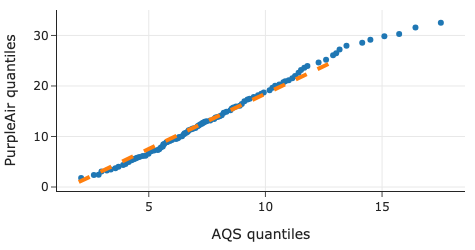

In [12]:
fig = px.scatter(perc_df, x='aqs_qs', y='pa_qs',
                 labels={'aqs_qs': 'AQS quantiles',
                         'pa_qs': 'PurpleAir quantiles'},
                 width=350, height=250)


fig.add_trace(go.Scatter(x=[2, 13], y=[1, 25], 
               mode='lines', line=dict(dash='dash', width=4)))
fig.update_layout(showlegend=False)
fig

The quantile–quantile plot is roughly linear. We overlaid a dashed line with a slope of 2.2; it lines up the quantiles well, which indicates the spread of the PurpleAir measurements is about twice that of AQS.

What we can't see in the q–q plot or the side-by-side histograms is how the sensor readings vary together. Let's look at this next. First, we take a look at the distribution of difference between the two readings:

In [13]:
diffs = (nc4['pm25pa'] - nc4['pm25aqs'])

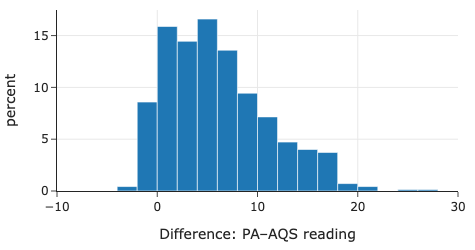

In [14]:
fig = px.histogram(diffs, histnorm='percent', 
                   width=350, height=250)

fig.update_xaxes(range=[-10,30], title="Difference: PA&#8211;AQS reading")
fig.update_traces(xbins=dict(
        start=-10.0, end=30.0, size=2)
                 )
fig.update_layout(showlegend=False)
fig.show()

If the instruments are in perfect agreement, we will see a spike at 0. If the instruments are in agreement and there is a measurement error with no bias, we expect to see a distribution centered at 0. Instead, we see that 90% of the time, the PurpleAir measurement is larger than the AQS 24-hour average, and about 25% of the time it is more than 10 µg/m<sup>3</sup> higher, which is a lot given the AQS averages tend to be between 5 µg/m<sup>3</sup> and 10 µg/m<sup>3</sup>.

A scatter plot can give us additional insight into the relationship between the measurements from these two instruments. Since we are interested in finding a general relationship, regardless of time and location, we include all of our average readings in the plot:

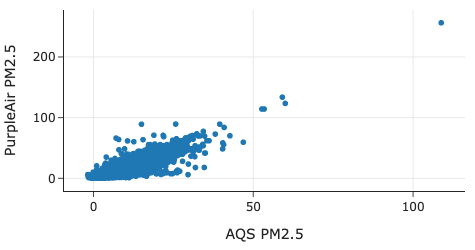

In [15]:
px.scatter(full_df, x='pm25aqs', y='pm25pa', width=350, height=250,
          labels={'pm25aqs':'AQS PM2.5', 'pm25pa':'PurpleAir PM2.5'})

While the relationship looks linear, all but a handful of readings are in the bottom-left corner of the plot. 
Let's remake the scatter plot and zoom in on the bulk of the data to get a better look. We also add a smooth curve to the plot to help us see the relationship better:

In [16]:
full_df = full_df.loc[(full_df['pm25aqs'] < 50)]

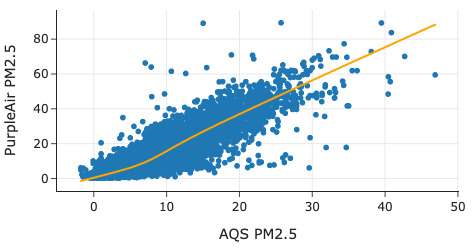

In [17]:
px.scatter(full_df, x='pm25aqs', y='pm25pa', 
           trendline='lowess', trendline_color_override="orange",
           labels={'pm25aqs':'AQS PM2.5', 'pm25pa':'PurpleAir PM2.5'},
           width=350, height=250)

The relationship looks roughly linear, but there is a slight bend in the curve for small values of AQS. When the air is very clean, the PurpleAir sensor doesn't pick up as much particulate matter and so is more accurate. Also, we can see that the curve should go through the point (0, 0). Despite the slight bend in the relationship,
the linear association (correlation) between these two measurements is high:

In [18]:
np.corrcoef(full_df['pm25aqs'], full_df['pm25pa'])

array([[1.  , 0.88],
       [0.88, 1.  ]])

Before starting this analysis, we expected that PurpleAir measurements
would generally overestimate the PM2.5. 
And indeed, this is reflected in the scatter plot, but we also see that there appears to be a strong linear relationship
between the measurements from these two instruments that will be helpful in calibrating the PurpleAir sensor. 